In [1]:
# Sentiment algorithm 3. Sequence of lemmas and POS-tag as multiple features input and binary sentiment classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_3'
model_variant = 'w_mask'

training_size = 30000
test_size = 10000

In [2]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import os
import time
import tensorflow as tf
from keras import callbacks
from keras import Input

%reload_ext autoreload
%autoreload 2
from helpers.sentiment_functions import gender_seq_to_single
from helpers.sentiment_functions import equal_genders
from helpers.sentiment_functions import encode_feature
from helpers.sentiment_functions import plot_sentence_lengths
from helpers.sentiment_functions import plot_confusion_matrix
from helpers.sentiment_functions import get_metrics
from helpers.sentiment_functions import xai_binary


pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [3]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
30000 samples are taken from the head for training
10000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
29995,3967,reaction,reaction,NOUN,0.006468,F
29996,3968,insane,insane,ADJ,0.000000,F
29997,3968,cyberbullying,cyberbullying,NOUN,0.000000,F
29998,3968,said,say,VERB,-0.564779,F


In [4]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_31200/3370681660.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_31200/3370681660.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
3320,3965,"[People, didn, u...","[People, didn, u...","[NOUN, AUX, VERB...",[-0.027128857560...,F
3321,3966,"[article, inspir...","[article, inspir...","[NOUN, VERB, NOU...",[-0.054393432894...,F
3322,3967,"[said, unprepare...","[say, unprepared...","[VERB, ADJ, NOUN]",[-0.564778745996...,F
3323,3968,"[insane, cyberbu...","[insane, cyberbu...","[ADJ, NOUN, VERB]","[0.0, 0.0, -0.56...",F


In [5]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,642,"[letter, support...","[letter, support...","[NOUN, VERB, VER...",[-0.046809910603...,F
1,1889,"[modesty, poncho...","[modesty, poncho...","[NOUN, NOUN, ADV...","[0.0, 0.0, -0.13...",F
2,2863,"[supposed, hard]","[suppose, hard]","[VERB, ADJ]",[0.0112744353661...,M
3,2158,"[latest, allegat...","[late, allegatio...","[ADJ, NOUN, VERB...",[-0.066733375239...,F
4,2287,"[turn, things, m...","[turn, thing, mo...","[VERB, NOUN, NOU...",[-0.064844843022...,F
...,...,...,...,...,...,...
3320,3533,"[square, wear, t...","[square, wear, t...","[VERB, VERB, NOUN]","[0.0, 0.25620491...",M
3321,1859,"[marker, creativ...","[marker, creativ...","[NOUN, ADV, VERB...","[0.0, 0.0, -0.20...",F
3322,3736,"[m, mocking, mov...","[m, mock, movement]","[AUX, VERB, NOUN]","[0.0, 0.0, 0.037...",F
3323,3644,"[wasn, aware, ha...","[wasn, aware, ha...","[VERB, ADJ, VERB...","[0.0, -0.0157154...",F


<AxesSubplot:>

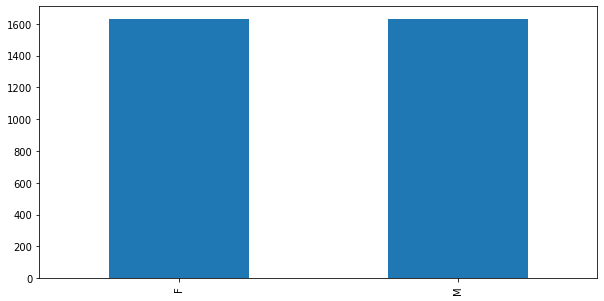

In [6]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

No handles with labels found to put in legend.


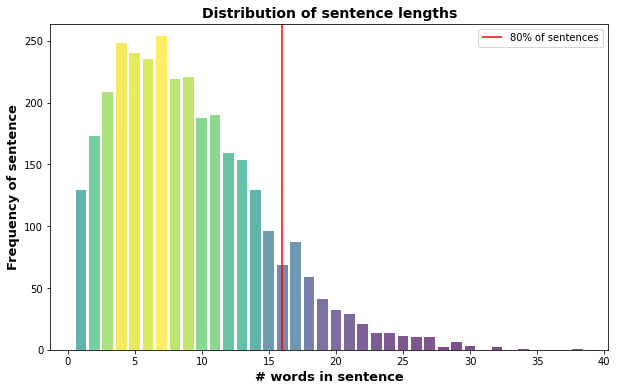

Decision boundary / 80 pct of sentence lengths is: 16


In [7]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [8]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size_lemma = encode_feature(train_data['Lemma'], test_data['Lemma'])
train_data['POS_enc'], test_data['POS_enc'], vocab_size_pos = encode_feature(train_data['POS'], test_data['POS'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train_lemma = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_train_pos = pad_sequences(train_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

X_test_lemma = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test_pos = pad_sequences(test_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [9]:
# ONE-HOT TARGET (GENDER)
le = LabelEncoder()
le.classes_ = ['M', 'F']

y_train = le.transform(train_data['Gender'])
y_test = le.transform(test_data['Gender'])

y_train = to_categorical(y_train)

print('[M] =', le.transform(['M']), '=', to_categorical(le.transform(['M']),2))
print('[F] =', le.transform(['F']), '=', to_categorical(le.transform(['F']),2))

[M] = [0] = [[1. 0.]]
[F] = [1] = [[0. 1.]]


In [10]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

my_callbacks = [earlystopping, tensorboard_cb]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lemma_input (InputLayer)        [(None, 16)]         0                                            
__________________________________________________________________________________________________
POS_input (InputLayer)          [(None, 16)]         0                                            
__________________________________________________________________________________________________
lemma_embedding (Embedding)     (None, 16, 128)      691584      lemma_input[0][0]                
__________________________________________________________________________________________________
POS_embedding (Embedding)       (None, 16, 128)      2176        POS_input[0][0]                  
______________________________________________________________________________________________

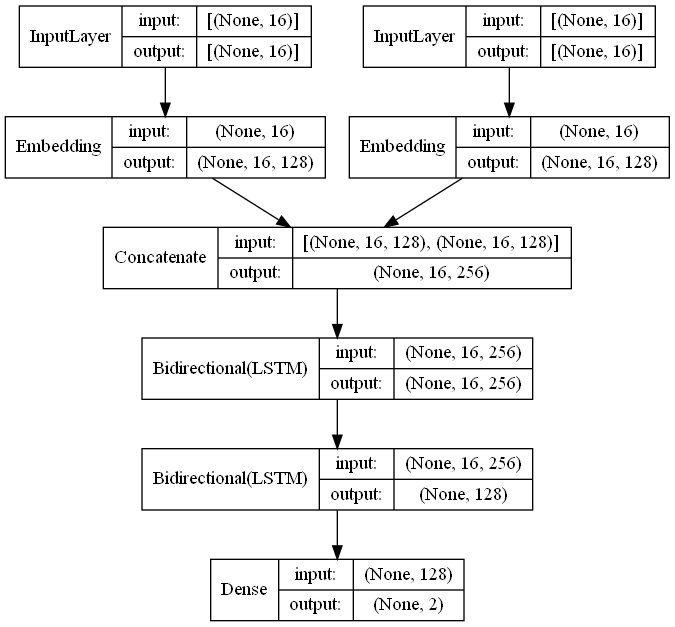

In [11]:
# DEFINING AND PLOTTING MODEL
embedding_dim = 128

lemma_input = Input(shape=(max_len), name='lemma_input')
pos_input = Input(shape=(max_len), name='POS_input')

lemma_embedding = layers.Embedding(vocab_size_lemma+1, embedding_dim, input_length=max_len, name="lemma_embedding", mask_zero=True)(lemma_input)
pos_embedding = layers.Embedding(vocab_size_pos+1, embedding_dim, input_length=max_len, name="POS_embedding")(pos_input)

concat = layers.Concatenate()([lemma_embedding, pos_embedding])

bidir_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(concat)

bidir_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))(bidir_1)

output = layers.Dense(2, activation="softmax", name='output')(bidir_2)

model = keras.Model(inputs=[lemma_input, pos_input], outputs=[output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [12]:
# FITTING MODEL

history = model.fit([X_train_lemma, X_train_pos], y_train, epochs=20, callbacks=my_callbacks, validation_split=0.2)


Epoch 1/20
82/82 [==============================] - 22s 130ms/step - loss: 0.5665 - accuracy: 0.6736 - val_loss: 0.4514 - val_accuracy: 0.7607
Epoch 2/20
82/82 [==============================] - 8s 103ms/step - loss: 0.2315 - accuracy: 0.9044 - val_loss: 0.4434 - val_accuracy: 0.7853
Epoch 3/20
82/82 [==============================] - 8s 103ms/step - loss: 0.1012 - accuracy: 0.9608 - val_loss: 0.6729 - val_accuracy: 0.7837
Epoch 4/20
82/82 [==============================] - 8s 100ms/step - loss: 0.0704 - accuracy: 0.9743 - val_loss: 0.7861 - val_accuracy: 0.7607
Epoch 5/20
82/82 [==============================] - 8s 96ms/step - loss: 0.0489 - accuracy: 0.9793 - val_loss: 0.7941 - val_accuracy: 0.7745
Epoch 6/20
82/82 [==============================] - 8s 94ms/step - loss: 0.0402 - accuracy: 0.9839 - val_loss: 0.9411 - val_accuracy: 0.7715
Epoch 7/20
82/82 [==============================] - 8s 98ms/step - loss: 0.0305 - accuracy: 0.9858 - val_loss: 1.2051 - val_accuracy: 0.7669


red is training, blue is validation


<Figure size 432x288 with 0 Axes>

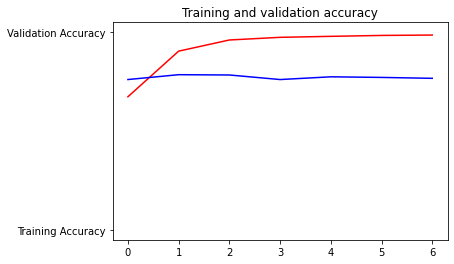

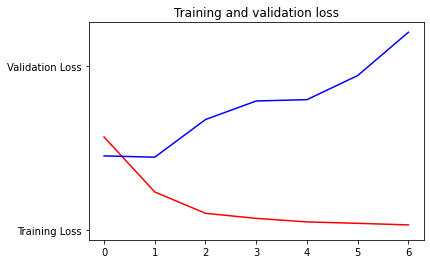

<Figure size 432x288 with 0 Axes>

In [13]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [14]:
# PREDICT TEST DATA
y_pred = model.predict([X_test_lemma, X_test_pos])
y_pred = y_pred.argmax(axis=-1)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [15]:
# SAVING MODEL
model.save('saved_models/' + model_name + '/' + model_variant + '.h5')

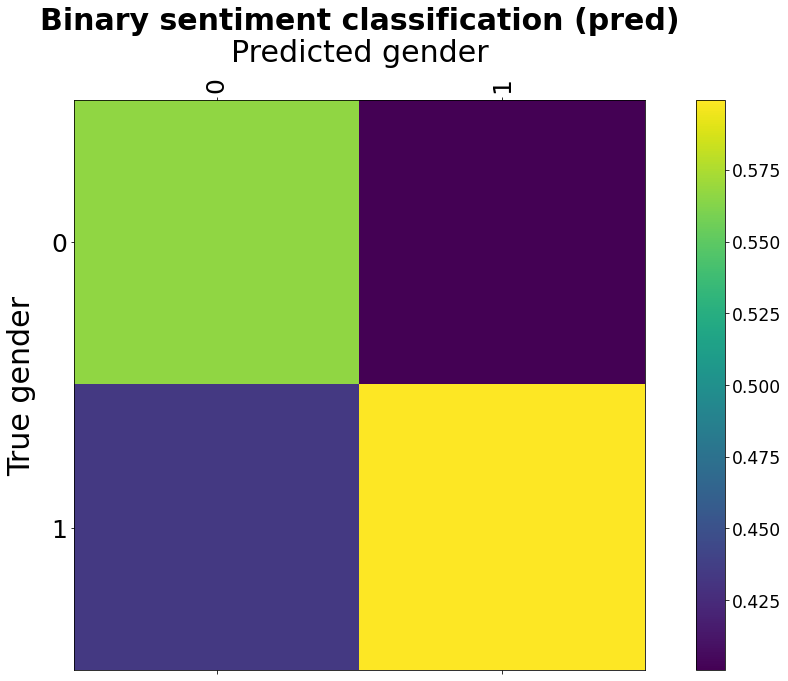

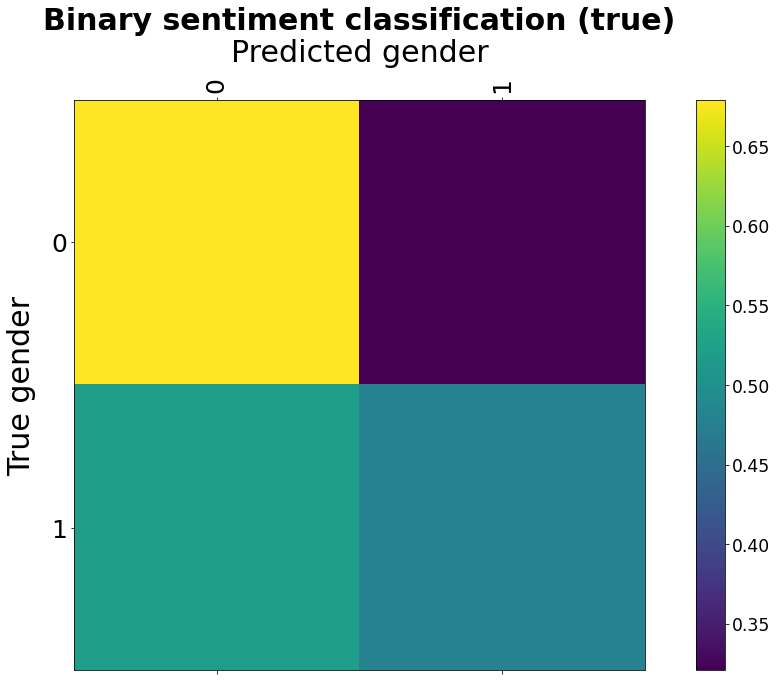

In [16]:
# PLOTTING CONFUSION MATRIX
plot_confusion_matrix(np.array(y_test).flatten(), y_pred, 'Binary sentiment classification', 'Predicted gender', 'True gender')

In [17]:
# PRINTING METRICS
sentiment_vocab = ['M', 'F']
get_metrics(y_test, y_pred, sentiment_vocab, 'Gender')

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\BAC\Ezra\sentiment\models\helpers\sentiment_functions.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.57,0.68,0.62,502.0
1,F,0.60,0.48,0.53,502.0


In [18]:
# USE XAI ON PREDICTIONS
xai_binary(y_pred[:100], test_data, 2)


---------------------------------------------------------------------------------------
The sentence: "The Challenge: How do you build a business case for potentially costly changes to improve the overall customer experience?".

Was predicted to be masculine (0).

Most masculine words in sentence are:

'business' with a polarity of -0.65
'customer' with a polarity of -0.39

---------------------------------------------------------------------------------------
The sentence: ""In Europe now, you need decisive action, you need overkill.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'decisive' with a polarity of 0.0
'decisive' with a polarity of 0.0

---------------------------------------------------------------------------------------
The sentence: "Indian Point has layers upon layers of safety and security systems, so there are back-ups to the back-ups.".

Was predicted to be masculine (0).

Most masculine words in sentence are:

'systems' with a polarity